### Latent Semantic Indexing

Latent Semantic Indexing is a simplified variation of Principal Component Analysis. It is mainly designed for Natural Language Processing. Since most document term matrices are sparse, the covariance matrix requirement of PCA does not work very well. In LSI, we directly do the singular value decomposition on document term matrix and then use the top $K$ corresponding eigenvectors to do dimension reduction. Usually in NLP, $K$ is 100 by default which implies 100 main topics of the text files.

Again, Andrew Ng didn't spend a lot of time on this topic (given that he proposed a more popular method called Latent Dirichlet Analysis), we can use the material from univeristy of colorado as a referene.

http://lsa.colorado.edu/papers/JASIS.lsi.90.pdf

To compare how similar two text files are, we can simply compute cosine similarity of the corresponding eigenvectors. For more details of cosine similarity, please check Wikipedia link below.

https://en.wikipedia.org/wiki/Cosine_similarity

As this script involves a lot of NLP preprocessing, for more details of NLP, you can check the link below

https://github.com/je-suis-tm/machine-learning/blob/master/naive%20bayes.ipynb

For more details of PCA and SVD, you can click the link below

https://github.com/je-suis-tm/machine-learning/blob/master/principal%20component%20analysis.ipynb

In [1]:
import os
import numpy as np
import pandas as pd
import nltk.tokenize
import nltk.corpus
import nltk.stem
import sklearn.decomposition
import matplotlib.pyplot as plt
import scipy.linalg
os.chdir('K:\ecole\github')

In [2]:
#convert text into a list of words
#we can use stemming and lemmatization to improve efficiency
#for instance, we have words walked,walking,walks
#with nltk package, we can revert all of them to walk
def text2list(text,stopword,lower=True,lemma=False,stemma=False):

    text_clean=text if lower==False else text.lower()
    
    #tokenize and remove stop words
    token=[i for i in nltk.tokenize.RegexpTokenizer(r'\w+').tokenize(text_clean) if i not in stopword]
    
    #lemmatization
    if lemma:
        text_processed=[nltk.stem.wordnet.WordNetLemmatizer().lemmatize(i) for i in token]
    else:
        text_processed=token
        
    #stemming
    if stemma:
        output=[nltk.stem.PorterStemmer().stem(i) for i in text_processed]
    else:
        output=text_processed
    
    #remove numbers as they are stopword as well
    for i in [ii for ii in output]:
        try:
            float(i)
            output.remove(i)
        except:
            pass
    
    return [i for i in output if i not in stopword]

In [3]:
#create document term matrix with 3 different weights
#in sklearn they are
#sklearn.feature_extraction.text.CountVectorizer(binary=True)
#sklearn.feature_extraction.text.TfidfVectorizer()
#sklearn.feature_extraction.text.CountVectorizer()
def create_document_term_matrix(df,vocabulary,binary=False,tfidf=False):
    
    document_term_matrix=np.zeros((len(vocabulary),len(df)))
    
    if binary:
        for i in df.index:   
            for j in df['word'][i]:
                document_term_matrix[vocabulary.index(j),i]=1
    elif tfidf:
        for i in df.index:   
            for j in df['word'][i]:
                tf=df['word'][i].count(j)/len(df['word'][i])
                idf_numerator=len(df)
                idf_denominator=len([ii for ii in df['word'] if j in ii])
                
                #laplace smoothing
                if idf_denominator==0:
                    idf_numerator+=1
                    idf_denominator+=1
                    tf=1/(len(df['word'][i])*2)
                    
                idf=np.log(idf_numerator/idf_denominator)
                document_term_matrix[vocabulary.index(j),i]=tf*idf
    
    #use term frequency by default
    else:
        for i in df.index:   
            for j in df['word'][i]:
                document_term_matrix[vocabulary.index(j),i]=df['word'][i].count(j)

    return document_term_matrix

In [4]:
#frobenius norm
#which can be effectively computed by
#np.linalg.norm
#scipy.linalg.norm
def frobenius_norm(vector):
    return sum([element**2 for element in vector])**0.5

In [5]:
#compute cosine similarity matrix
#this can be done via
#sklearn.metrics.pairwise.cosine_similarity(Vt[:num_of_dims].T)
def create_cosine_similarity(Vt,num_of_dims):
    
    cosine_similarity=np.ones((Vt.shape[1],Vt.shape[1]))    
    for i in range(Vt.shape[1]):
        vec_i=Vt[:num_of_dims,i]
        norm_i=frobenius_norm(vec_i)
        for j in range(i+1,Vt.shape[1]):
            vec_j=Vt[:num_of_dims,j]
            norm_j=frobenius_norm(vec_j)
            
            #avoid divided by zero
            if norm_i==0:
                norm_i=1
            if norm_j==0:
                norm_j=1
            cosine_similarity[i,j]=vec_i@vec_j/frobenius_norm(vec_i)/frobenius_norm(vec_j)
            cosine_similarity[j,i]=cosine_similarity[i,j]
            
    return cosine_similarity

### Preprocessing

In [6]:
stopword=nltk.corpus.stopwords.words('english')+['u',
 'beyond',
 'within',
 'around',
 'would',
 'b',
 'c',
 'e',
 'f',
 'g',
 'h',
 'j',
 'k',
 'l',
 'n',
 'p',
 'q',
 'r',
 'u',
 'v',
 'w',
 'x',
 'z',
 'first']

In [7]:
#usually in lsi
#the recommended number is 100 rank approximation
#unfortunately in this case, we only have 36 eigenvalues
#so lets make the number 10
num_of_dims=10

In [8]:
#the raw data really comes from my email
df=pd.read_csv('spam.csv')

In [9]:
#tokenization
tokens=[]
for i in df['text'].tolist():
    tokens.append(text2list(i,stopword,lower=True,lemma=True))            
df['word']=tokens

#get vocabulary
vocabulary=sorted(list(set([j for i in df['word'] for j in i])))

#get document term matrix
#using pandas really make things slow af
document_term_matrix=create_document_term_matrix(df,vocabulary)

In [10]:
#svd approach
#the only preprocessing is document term matrix
#unlike pca, no z score or covariance matrix
U,D,Vt=scipy.linalg.svd(document_term_matrix)

In [11]:
#dimension reduction
lsi_svd=document_term_matrix@Vt[:num_of_dims].T

### Topic Modelling

In [12]:
#sklearn lsi and pca
clf=sklearn.decomposition.TruncatedSVD(num_of_dims)
lsi_skl=clf.fit_transform(document_term_matrix)

clf=sklearn.decomposition.PCA(num_of_dims)
lsi_pca=clf.fit_transform(document_term_matrix)

In [13]:
#for sklearn svd, some decimals and signs are different
#overall the result is the same
#if u recall what happened in pca
#the basis vector can rotate freely in its own subspace
np.matrix.round(abs(lsi_svd),2)==np.matrix.round(abs(lsi_skl),2)

array([[ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True],
       ...,
       [ True,  True,  True, ...,  True,  True, False],
       [ True,  True,  True, ...,  True,  True,  True],
       [ True,  True,  True, ...,  True,  True,  True]])

In [14]:
#for pca, the result is different
#because pca has to work on covariance matrix
#for a sparse matrix like text corpora
#lsi approach is more helpful
#check quora for more details on the difference
# https://www.quora.com/Do-PCA-and-LSI-give-similar-results
np.matrix.round(abs(lsi_svd),2)==np.matrix.round(abs(lsi_pca),2)

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

### Text Matching

In [15]:
#to further examine the proximity between two emails
#we just need to check the eigenvectors on matrix Vt
#the metric we look at is called cosine similarity
cosine_similarity=create_cosine_similarity(Vt,num_of_dims)

In [16]:
#lets see which emails are closely related
#apparently 0,10,11,12
#if u check the dataframe below, they are ads for student trips...
D={}
for i in range(cosine_similarity.shape[1]):
    for j in range(i+1,cosine_similarity.shape[1]):
        D[(i,j)]=cosine_similarity[i,j]
sorted(D.items(),key=lambda x:x[1],reverse=True)

[((10, 11), 0.9999983507940531),
 ((0, 10), 0.9997181952777925),
 ((0, 11), 0.9996824969602651),
 ((10, 12), 0.9963723868612213),
 ((11, 12), 0.996303500704384),
 ((0, 12), 0.9962639879337088),
 ((22, 26), 0.9817960612675118),
 ((7, 35), 0.980340721639682),
 ((19, 20), 0.9802229227284583),
 ((19, 26), 0.9597769062682774),
 ((20, 26), 0.9590243784864261),
 ((3, 26), 0.94538814984696),
 ((7, 8), 0.9438234715323754),
 ((14, 25), 0.9319425552022431),
 ((18, 24), 0.9299699626077859),
 ((8, 31), 0.9299127088739522),
 ((3, 19), 0.9298137295249614),
 ((3, 22), 0.9253964131621899),
 ((22, 23), 0.9221014449846265),
 ((3, 23), 0.9184093554414788),
 ((6, 26), 0.9158413417342154),
 ((20, 22), 0.9127644947485978),
 ((6, 22), 0.9103065955016808),
 ((19, 22), 0.9082596973579775),
 ((13, 23), 0.9032484434985844),
 ((9, 24), 0.8992623814233736),
 ((6, 20), 0.8981494607008308),
 ((6, 19), 0.8979530351454155),
 ((14, 23), 0.8938962084231047),
 ((23, 26), 0.8925416562146964),
 ((13, 14), 0.8921459604470472

In [17]:
#check the original emails
df

,text,spam,word
0,"﻿Hi, We are a group of students who love trave...",1,"[hi, group, student, love, traveling, organize..."
1,"Whether you like it or not, the world is evol...",1,"[whether, like, world, evolving, matter, time,..."
2,"MATLAB EXPO 2018 3 October | Silverstone, Nort...",0,"[matlab, expo, october, silverstone, northampt..."
3,Thank you for recently taking the time for you...,0,"[thank, recently, taking, time, phone, intervi..."
4,You protect yourself. So why not your income? ...,1,"[protect, income, income, protection, cover, p..."
5,Don't miss out on our best pricing for the 201...,0,"[miss, best, pricing, wolfram, technology, con..."
6,Dear Customer. Here's your HMRC Transaction Co...,1,"[dear, customer, hmrc, transaction, confirmati..."
7,"Your budget is in place, you’ve found your dr...",1,"[budget, place, found, dream, area, time, star..."
8,"Dear Applicant/Former Applicant, In order to c...",0,"[dear, applicant, former, applicant, order, co..."
9,We’re writing to share important information a...,0,"[writing, share, important, information, accou..."


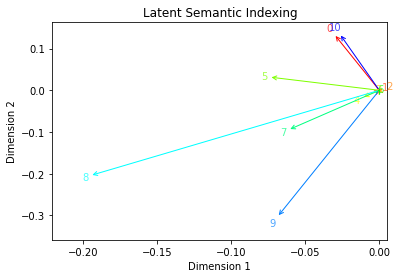

In [18]:
#use pca to shrink the dimensions of eigenvectors to 2
clf=sklearn.decomposition.PCA(n_components=2)
viz=clf.fit_transform(Vt[:num_of_dims].T)

#rainbow colors
colors=['#ff0000',
 '#ff4000',
 '#ff7f00',
 '#ffbf00',
 '#ffff00',
 '#7fff00',
 '#00ff00',
 '#00ff80',
 '#00ffff',
 '#007fff',
 '#0000ff',
 '#4500ff',]

#for simplicity, we only visualize the first 11 emails
#as you can see, vector 0 and 10 are almost identical
for i in range(11):
    plt.annotate(str(i),xy=(0,0),
                 xytext=(viz[i][0],viz[i][1]),
                arrowprops=dict(arrowstyle="<-",color=colors[i]),
                color=colors[i],alpha=0.7)

plt.title('Latent Semantic Indexing')
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.xlim(viz[:12,0].min()*1.1,viz[:12,0].max()*1.1)
plt.ylim(viz[:12,1].min()*1.1,viz[:12,1].max()*1.1)
plt.show()